In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import StrMethodFormatter

import math
import sys

import skinny
import helpers 
import dpautils

from scipy import stats
from array import array
from operator import xor
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#N=int(sys.argv[1])
#std=float(sys.argv[2])
#number_of_experiments=int(sys.argv[3])

In [3]:
N=25
std=0.5
number_of_experiments=5

In [4]:

keys=np.random.randint(2147483647, 9223372036854775807, size=number_of_experiments, dtype=np.int64) 

P=helpers.gen_plaintexts(N)

In [5]:
def compute_intermediate_values(P,K): #Plaintexts list, K int
    known_RK=[]
    IS=[] #List of each p's IS' 
    IS2=[]
    CP=[] #P'
    CP_r2=[]
    for plaintext in P:
        #valid_modes = ['ECB', 'CTR', 'CBC', 'PCBC', 'CFB', 'OFB'] 
        cipher = skinny.SkinnyCipher(K,64,64) #TK1
        cipher.encrypt(plaintext)
        p=cipher.intermediary_values[0]
        RK=cipher.intermediary_values[1]
        p2=cipher.intermediate_values_round_2[0]
        RK2=cipher.intermediate_values_round_2[1]

        p_xor_k = [array('B',map(xor,p[0], RK[0])),
                   array('B',map(xor, p[1], RK[1])),
                   array('B',map(xor, p[2], RK[2])),
                   array('B',map(xor, p[3], RK[3]))
                  ] 
        p_xor_k=np.matrix(p_xor_k)
        
        s=[]
        sbox4 = array('B', [12, 6, 9, 0, 1, 10, 2, 11, 3, 8, 5, 13, 4, 14, 7, 15])
        for x in np.nditer(p_xor_k): 
            s.append(sbox4[x])
            
        IS.append(np.matrix(s)) 
        CP.append(np.asmatrix(p).flatten())
        

        p_xor_k = [array('B',map(xor,p2[0], RK2[0])),
                   array('B',map(xor, p2[1], RK2[1])),
                   array('B',map(xor, p2[2], RK2[2])),
                   array('B',map(xor, p2[3], RK2[3]))
                  ] 
        p_xor_k=np.matrix(p_xor_k)
        
        s=[]
        sbox4 = array('B', [12, 6, 9, 0, 1, 10, 2, 11, 3, 8, 5, 13, 4, 14, 7, 15])
        for x in np.nditer(p_xor_k): 
            s.append(sbox4[x])
            
        IS2.append(np.matrix(s)) 
        CP_r2.append(np.asmatrix(p2).flatten())
        
    return [IS, CP, np.matrix(RK), CP_r2, np.matrix(RK2), IS2]

def recover_pk(val):
    val=np.array(val).reshape(4,4)

    # Inverse Mix Col
    mix_1 = val[0] ^ val[3]
    mix_2 = val[1] ^ val[3]
    mix_3 = val[2] ^ mix_2
    internal_state = [val[1], mix_3,mix_2, mix_1]

    # Inverse Shift Rows 
    internal_state = [internal_state[0],
                    [internal_state[1][1], internal_state[1][2], internal_state[1][3], internal_state[1][0]],
                    [internal_state[2][2], internal_state[2][3], internal_state[2][0], internal_state[2][1]],
                    [internal_state[3][3], internal_state[3][0], internal_state[3][1], internal_state[3][2]],]

    return internal_state

def gen_pk(val):
    internal_state=np.array(val).reshape(4,4)

    internal_state = [internal_state[0],
                              array('B', [internal_state[1][3], internal_state[1][0], internal_state[1][1], internal_state[1][2]]),
                              array('B', [internal_state[2][2], internal_state[2][3], internal_state[2][0], internal_state[2][1]]),
                              array('B', [internal_state[3][1], internal_state[3][2], internal_state[3][3], internal_state[3][0]])]


    # MixColumns
    mix_1 = array('B', map(xor, internal_state[1], internal_state[2]))
    mix_2 = array('B', map(xor, internal_state[0], internal_state[2]))
    mix_3 = array('B', map(xor, internal_state[3], mix_2))

    internal_state = [mix_3, internal_state[0], mix_1, mix_2]

    return internal_state


def addConst(val,round_num):
    internal_state=np.array(val).reshape(4,4)
    round_constants = array('B', [0x01, 0x03, 0x07, 0x0F, 0x1F, 0x3E, 0x3D, 0x3B, 0x37, 0x2F, 0x1E, 0x3C, 0x39, 0x33,
                                  0x27, 0x0E, 0x1D, 0x3A, 0x35, 0x2B, 0x16, 0x2C, 0x18, 0x30, 0x21, 0x02, 0x05, 0x0B,
                                  0x17, 0x2E, 0x1C, 0x38, 0x31, 0x23, 0x06, 0x0D, 0x1B, 0x36, 0x2D, 0x1A, 0x34, 0x29,
                                  0x12, 0x24, 0x08, 0x11, 0x22, 0x04, 0x09, 0x13, 0x26, 0x0c, 0x19, 0x32, 0x25, 0x0a,
                                  0x15, 0x2a, 0x14, 0x28, 0x10, 0x20])

    round_constant = round_constants[round_num]
    c0 = round_constant & 0xF
    c1 = round_constant >> 4
    c2 = 0x2
    internal_state[0][0] ^= c0
    internal_state[1][0] ^= c1    
    internal_state[2][0] ^= c2
    return internal_state

In [6]:
intermediate_values=[]
for key in keys:
    val=compute_intermediate_values(P,int(key))
    interm_values=val[0]
    clear_text=val[1]
    TK1_first=val[2].A1
    TK1_second=val[4].A1
    clear_text2=val[3]
    internal_state_round2=val[5]

    T = dpautils.gen_traces(interm_values, std)
    T2 = dpautils.gen_traces(internal_state_round2, std)
    intermediate_values.append([interm_values,clear_text,TK1_first,clear_text2,T,T2,TK1_second])

In [7]:
simultanous_success_rate_pr_n=[]
Ns=list(range(49,N,1))
full_key_guess=[]
probs_pr_n=[]
for n in Ns:
    probs=[]
    
    for i,key in enumerate(keys):
        clear_text = intermediate_values[i][1]
        TK1 = intermediate_values[i][2]
        T = intermediate_values[i][4]
        T2= intermediate_values[i][5]

        TK1_0_guess=[]
        TK1_1_guess=[]
        TK1_2_guess=[]
        TK1_3_guess=[]

        # Attack TK1_0 nibble i (first row of TK1)
        for j in range(4): 
            t=T[:n]
            ct=clear_text[:n]
            nibble_guess=dpautils.simultanous_atk(t,ct,j)
            TK1_0_guess.append(nibble_guess)

        # Attack TK1_1 nibble i (second row of TK1)
        for j in range(4): 
            t=T[:n]
            ct=clear_text[:n]
            nibble_guess=dpautils.individual_atk(t,ct,(j+8))
            TK1_1_guess.append(nibble_guess)

        SK=TK1_0_guess+TK1_0_guess+TK1_1_guess+TK1_0_guess
        
        # Compute intermediate values for round 2
        round1_interm_results=[]
        for p in clear_text:
            s=[]
            p_xor_k=np.bitwise_xor(p,SK)
            sbox4 = array('B', [12, 6, 9, 0, 1, 10, 2, 11, 3, 8, 5, 13, 4, 14, 7, 15])
            for x in np.nditer(p_xor_k): 
                s.append(sbox4[x])
            s=gen_pk(addConst(s,1))
            round1_interm_results.append(np.matrix(s))
        # Testa OK ^


        # Attack TK1_2 nibble i (first row of TK1)
        for j in range(4): 
            t=T2[:n]
            ct=round1_interm_results[:n]
            nibble_guess=dpautils.simultanous_atk(t,ct,j)
            TK1_2_guess.append(nibble_guess)
        # Attack TK1_3 nibble i (second row of TK1)
        for j in range(4): 
            t=T2[:n]
            ct=round1_interm_results[:n]
            nibble_guess=dpautils.individual_atk(t,ct,(j+8))
            TK1_3_guess.append(nibble_guess)

        TK1_guess=np.array(TK1_0_guess+TK1_1_guess+TK1_2_guess+TK1_3_guess)
        TK1_corr=np.array(TK1_first+TK1_second)

        #_____SUCCESS/FAIL_________________
        if(np.array_equal(TK1_guess,TK1_corr)):
            probs.append(1)
        else:
            probs.append(0)
    probs_pr_n.append(np.average(probs))


[ 5  7  9 14  5  7  9 14  8 12 12  0  5  7  9 14]
[5, 7, 9, 14]
[8, 12, 12, 0]


In [8]:
print(probs_pr_n)

[]


No handles with labels found to put in legend.


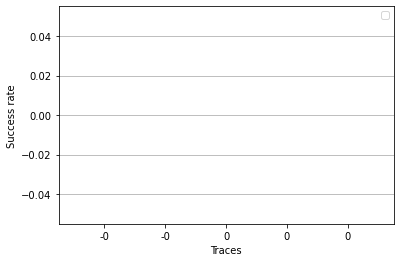

In [9]:


probs_pr_n.insert(0, 0.0)
#xaxs=np.array(list(range(0,len(plot_0),1)))
#plot_label= "TK1_0 recovery rate | experiments: "+ str(len(keys))+", std: "+str(std)
plt.figure()
plt.ylabel('Success rate')
plt.xlabel('Traces')
plt.plot(np.array(probs_pr_n), c="black")
plt.grid(axis='y')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.legend()
plt.draw()
plt.savefig('success_rate_full_key_recovery')